In [121]:
!pip install -Uqq pyts fastbook binance-connector pandas_ta

In [122]:
# Import necessary libraries
import datetime as dt
import os
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import pandas as pd
import pandas_ta as ta
import pywt
import pywt.data
import re
from pyts.image import GramianAngularField
from PIL import Image as im
from binance.spot import Spot
%matplotlib inline 

import fastbook
fastbook.setup_book()
from fastbook import *
import matplotlib.image

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [123]:
#pywt.wavelist('sym')

In [124]:
SYMBOL = 'BTCUSDT'
INTERVAL = '1m'
INPUT_SIZE = 30
RAW_INPUT_SIZE = 100
THRESHOLD = 0.97
TRADING_PERCENT = 0.1
INITIAL_USD_BALANCE = 1000
STOP_PROFIT = 0.004
STOP_LOSS = 0.004
ORDER_LIFE = 5

In [125]:
def to_dataframe(data):
   np_data = np.array(data)
   df = pd.DataFrame(data=np_data[:, 1:6],
                     index=np_data[:, 0],
                     columns=np_data[0, 1:6])
   df.columns = ['open', 'high', 'low', 'close', 'volume']
   df['open'] = pd.to_numeric(df['open'])
   df['high'] = pd.to_numeric(df['high'])
   df['low'] = pd.to_numeric(df['low'])
   df['close'] = pd.to_numeric(df['close'])
   df['volume'] = pd.to_numeric(df['volume'])


In [126]:
rest_client = Spot()
START_TIME = 0
def prepare_dataset():
    first_data = rest_client.klines(SYMBOL, INTERVAL, limit=500)
    df = to_dataframe(first_data)
    startTime = 4
    #while endTime > START_TIME:
    #    data = rest_client.klines(SYMBOL, INTERVAL, limit=500)

In [127]:
wavelet_type = 'sym15'
w = pywt.Wavelet(wavelet_type)
def denoise(data):
    if len(data) > 0:
        maxlev = pywt.dwt_max_level(len(data), w.dec_len)
        coeffs = pywt.wavedec(data, wavelet_type, level=maxlev)
        coeffs[-1] = np.zeros_like(coeffs[-1])
        datarec = pywt.waverec(coeffs, wavelet_type)
        return datarec
    else:
        return data

In [128]:
BTC = pd.read_csv("../input/bitcoin-btcusdt/Bitcoin_BTCUSDT.csv")
df = BTC.iloc[-10000:].reset_index(drop=True)

In [129]:

def calc_label(dataset, position):
    price = dataset['close'].to_numpy()[position]
    stop_loss = STOP_LOSS * price
    stop_profit = STOP_PROFIT * price
    label = "wait"
    bearish_stop_loss = price + stop_loss
    bearish_stop_profit = price - stop_profit
    bullish_stop_loss = price - stop_loss
    bullish_stop_profit = price + stop_profit
    for i in range(1, ORDER_LIFE+1):
        max_price = dataset['high'].to_numpy()[position+i]
        low_price = dataset['low'].to_numpy()[position+i]
        if low_price > bullish_stop_loss:
            if max_price >= bullish_stop_profit:
                label = "buy"
                break
        else:
            break
    for i in range(1, ORDER_LIFE+1):
        max_price = dataset['high'].to_numpy()[position+i]
        low_price = dataset['low'].to_numpy()[position+i]
        if max_price < bearish_stop_loss:
            if low_price <= bearish_stop_profit:
                label = "sell"
                break
        else:
            break
    return label
        
       

    

In [130]:
L = len(df['close'])
df_labels = [None]*L
for i in range(0, L-ORDER_LIFE):
    df_labels[i] = calc_label(df, i)

df_labeled_raw = df.copy()
df_labeled_raw['label'] = df_labels

In [131]:
df_labeled_raw[150:300]

,timestamp,open,high,low,close,volume,label
150,2022-05-16 16:16:00,29395.11,29395.12,29353.08,29363.26,65.31633,wait
151,2022-05-16 16:17:00,29363.25,29395.12,29321.99,29343.82,82.56491,buy
152,2022-05-16 16:18:00,29343.82,29448.89,29315.24,29448.81,157.70268,wait
153,2022-05-16 16:19:00,29448.81,29470.58,29421.80,29449.74,63.57436,wait
154,2022-05-16 16:20:00,29449.99,29478.43,29434.47,29449.06,53.66338,wait
...,...,...,...,...,...,...,...
295,2022-05-16 18:41:00,29897.77,29902.35,29872.71,29887.70,22.79386,wait
296,2022-05-16 18:42:00,29887.69,29914.69,29887.69,29903.35,23.05728,wait
297,2022-05-16 18:43:00,29903.35,29924.94,29903.34,29904.90,40.32597,wait
298,2022-05-16 18:44:00,29904.91,29904.91,29860.00,29865.40,81.85236,wait


In [132]:


df = df_labeled_raw.iloc[:-ORDER_LIFE].reset_index(drop=True).copy()

In [133]:
DS_LENGTH = len(df['close'])
df

,timestamp,open,high,low,close,volume,label
0,2022-05-16 13:46:00,29672.83,29699.21,29531.56,29562.10,196.41880,wait
1,2022-05-16 13:47:00,29562.11,29630.00,29546.78,29587.17,127.45077,sell
2,2022-05-16 13:48:00,29587.17,29620.72,29523.32,29564.96,129.19324,buy
3,2022-05-16 13:49:00,29564.96,29607.93,29535.32,29572.31,132.21620,sell
4,2022-05-16 13:50:00,29572.30,29599.67,29450.00,29590.17,306.23555,wait
...,...,...,...,...,...,...,...
9990,2022-05-23 12:16:00,30533.76,30598.99,30533.75,30582.41,60.43965,wait
9991,2022-05-23 12:17:00,30582.40,30593.73,30577.47,30593.72,22.95281,wait
9992,2022-05-23 12:18:00,30593.73,30625.98,30569.96,30572.25,117.82663,wait
9993,2022-05-23 12:19:00,30572.25,30572.62,30539.06,30539.62,30.19423,wait


In [134]:
input_open = [None]*DS_LENGTH
input_high = [None]*DS_LENGTH
input_low = [None]*DS_LENGTH
input_close = [None]*DS_LENGTH
input_volume = [None]*DS_LENGTH
input_timestamp = [None]*DS_LENGTH
for i in range(0, DS_LENGTH):
    if i + 1 >= RAW_INPUT_SIZE:
        input_open[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].open.copy()
        input_high[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].high.copy()
        input_low[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].low.copy()
        input_close[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].close.copy()
        input_volume[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].volume.copy()
        input_timestamp[i] = df.iloc[i+1-RAW_INPUT_SIZE:i+1].timestamp.copy().reset_index(drop=True)
df['input_open'] = input_open
df['input_high'] = input_high
df['input_low'] = input_low
df['input_close'] = input_close
df['input_volume'] = input_volume
df['input_timestamp'] = input_timestamp
df = df.iloc[RAW_INPUT_SIZE:].copy().reset_index(drop=True)


In [135]:
df = df[df['label'] != 'wait'].reset_index(drop=True)

In [136]:
#print(df['input_timestamp'][0])

In [137]:
DS_LENGTH = len(df['close'])
denoised_input_open = [None]*DS_LENGTH
denoised_input_high = [None]*DS_LENGTH
denoised_input_low = [None]*DS_LENGTH
denoised_input_close = [None]*DS_LENGTH
denoised_input_volume = [None]*DS_LENGTH

for i in range(0, DS_LENGTH):
    denoised_input_open[i] = denoise(df['input_open'][i])
    denoised_input_high[i] = denoise(df['input_high'][i])
    denoised_input_low[i] = denoise(df['input_low'][i])
    denoised_input_close[i] = denoise(df['input_close'][i])
    denoised_input_volume[i] = denoise(df['input_volume'][i])

df['denoised_input_open'] = denoised_input_open
df['denoised_input_high'] = denoised_input_high
df['denoised_input_low'] = denoised_input_low
df['denoised_input_close'] = denoised_input_close
df['denoised_input_volume'] = denoised_input_volume

In [138]:
print(df.ta.indicators(as_list=True))

['aberration', 'above', 'above_value', 'accbands', 'ad', 'adosc', 'adx', 'alma', 'amat', 'ao', 'aobv', 'apo', 'aroon', 'atr', 'bbands', 'below', 'below_value', 'bias', 'bop', 'brar', 'cci', 'cdl_pattern', 'cdl_z', 'cfo', 'cg', 'chop', 'cksp', 'cmf', 'cmo', 'coppock', 'cross', 'cross_value', 'cti', 'decay', 'decreasing', 'dema', 'dm', 'donchian', 'dpo', 'ebsw', 'efi', 'ema', 'entropy', 'eom', 'er', 'eri', 'fisher', 'fwma', 'ha', 'hilo', 'hl2', 'hlc3', 'hma', 'hwc', 'hwma', 'ichimoku', 'increasing', 'inertia', 'jma', 'kama', 'kc', 'kdj', 'kst', 'kurtosis', 'kvo', 'linreg', 'log_return', 'long_run', 'macd', 'mad', 'massi', 'mcgd', 'median', 'mfi', 'midpoint', 'midprice', 'mom', 'natr', 'nvi', 'obv', 'ohlc4', 'pdist', 'percent_return', 'pgo', 'ppo', 'psar', 'psl', 'pvi', 'pvo', 'pvol', 'pvr', 'pvt', 'pwma', 'qqe', 'qstick', 'quantile', 'rma', 'roc', 'rsi', 'rsx', 'rvgi', 'rvi', 'short_run', 'sinwma', 'skew', 'slope', 'sma', 'smi', 'squeeze', 'squeeze_pro', 'ssf', 'stc', 'stdev', 'stoch', '

In [139]:
ind_list = ['qstick', 't3', 'cti', 'mad', 'ha', 'squeeze', 'aroon', 'bbands', 'kc', 'vwap', 'stoch'] #df.ta.indicators(as_list=True)
#indies_partition_size = 10
#p_ind_list = [ind_list[i:i + indies_partition_size] for i in range(0, len(ind_list), indies_partition_size)]
ind_columns = ['qstick', 't3', 'cti', 'mad', 'HA_low', 'SQZ_20_2.0_20_1.5', 'AROONU_14', 'BBU_5_2.0', 'KCBe_20_2', 'vwap', 'STOCHd_14_3_3']
#p_ind_list
#exclude_indies = ['above', 'above_value', 'open', 'high', 'low', 'close', 'volume']

In [140]:
#print(df.ta.indicators(as_list=True))

In [141]:
print(ind_list)

['qstick', 't3', 'cti', 'mad', 'ha', 'squeeze', 'aroon', 'bbands', 'kc', 'vwap', 'stoch', 'fisher']


In [142]:
for indi in ind_list:
    indi_result = {}
    new_cols = []
    for i in range(0, DS_LENGTH):
        indi_input = pd.DataFrame()
        indi_input['open'] = df['denoised_input_open'][i].copy()
        indi_input['high'] = df['denoised_input_high'][i].copy()
        indi_input['low'] = df['denoised_input_low'][i].copy()
        indi_input['close'] = df['denoised_input_close'][i].copy()
        indi_input['volume'] = df['denoised_input_volume'][i].copy()
        indi_input['timestamp'] = df['input_timestamp'][i].copy(
        ).reset_index(drop=True)
        indi_input.set_index(pd.DatetimeIndex(
            indi_input["timestamp"]), inplace=True)
        indi_fn = getattr(indi_input.ta, indi)
        data = indi_fn()
        if len(new_cols) == 0:
            if not isinstance(data, pd.Series):
                new_cols = new_cols + data.columns.to_numpy().tolist()
            else:
                new_cols = new_cols + [indi]
            for col_name in new_cols:
                indi_result[col_name] = [None]*DS_LENGTH
        for col_name in new_cols:
            if not isinstance(data, pd.Series):
                indi_result[col_name][i] = data[col_name]
            else:
                indi_result[col_name][i] = data
    for col_name in new_cols:
        if col_name in ind_columns:
            df[col_name] = indi_result[col_name]


In [143]:
gaf_transformer = GramianAngularField(method='difference', image_size=INPUT_SIZE)
df_gaf_input_open = [None]*DS_LENGTH
df_gaf_input_high = [None]*DS_LENGTH
df_gaf_input_low = [None]*DS_LENGTH
df_gaf_input_close = [None]*DS_LENGTH
df_gaf_input_volume = [None]*DS_LENGTH
for i in range(0, DS_LENGTH):
    if len(df['denoised_input_close'][i]) > 0:
        df_gaf_input_open[i] = gaf_transformer.fit_transform(df['denoised_input_open'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_high[i] = gaf_transformer.fit_transform(df['denoised_input_high'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_low[i] = gaf_transformer.fit_transform(df['denoised_input_low'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_close[i] = gaf_transformer.fit_transform(df['denoised_input_open'][i][-INPUT_SIZE:].reshape(1, -1))
        df_gaf_input_volume[i] = gaf_transformer.fit_transform(df['denoised_input_volume'][i][-INPUT_SIZE:].reshape(1, -1))
df['gaf_open'] = df_gaf_input_open
df['gaf_high'] = df_gaf_input_high
df['gaf_low'] = df_gaf_input_low
df['gaf_close'] = df_gaf_input_close
df['gaf_volume'] = df_gaf_input_volume


In [144]:
df = df.copy()

qstick


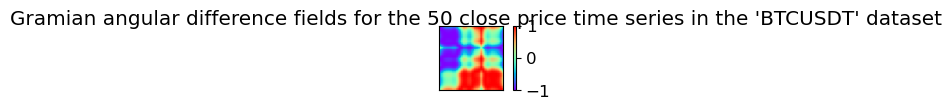

t3


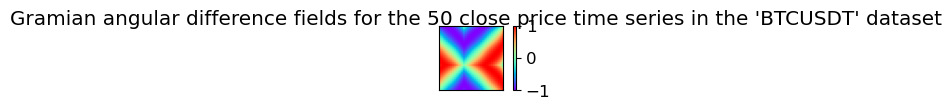

cti


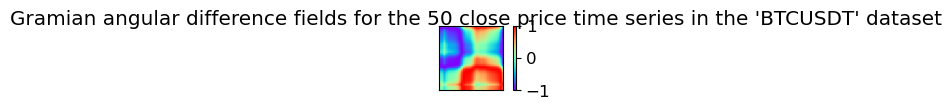

mad


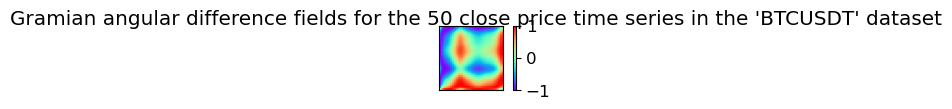

HA_low


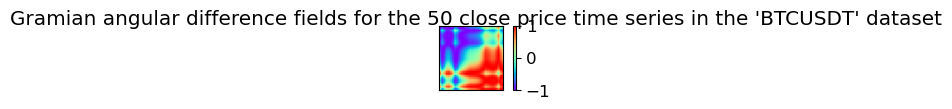

SQZ_20_2.0_20_1.5


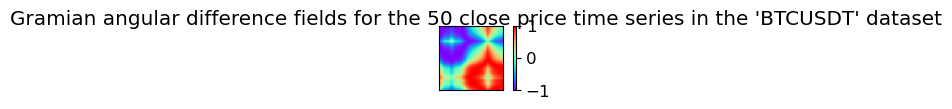

AROONU_14


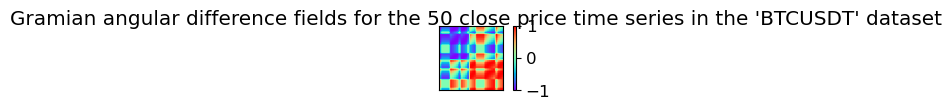

BBU_5_2.0


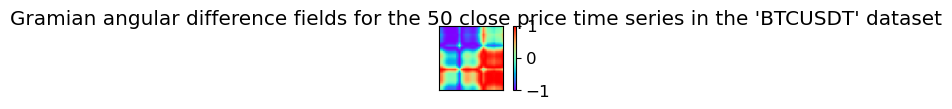

FISHERTs_9_1


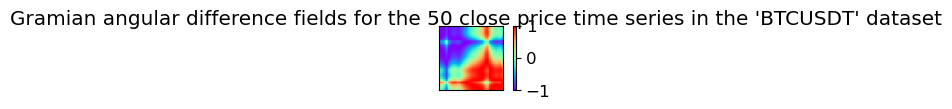

vwap


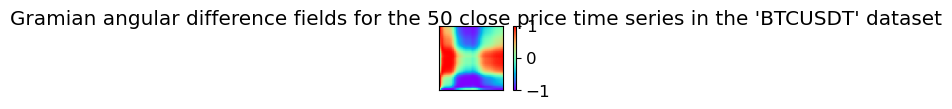

STOCHd_14_3_3


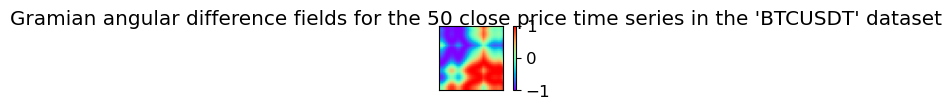

In [145]:
for col_name in ind_columns:
    print(col_name)
    gaf_col = [None]*DS_LENGTH
    for i in range(0, DS_LENGTH):
        if len(df['denoised_input_close'][i]) > 0:
            if isinstance(df[col_name][i], pd.Series):
                gaf_col[i] = gaf_transformer.fit_transform(
                    df[col_name][i][-INPUT_SIZE:].to_numpy().reshape(1, -1))
            else:
                gaf_col[i] = gaf_transformer.fit_transform(
                    df[col_name][i][-INPUT_SIZE:].reshape(1, -1))
    df[col_name] = gaf_col
    fig = plt.figure(figsize=(1, 1))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 1), axes_pad=0.1, share_all=True,
                     cbar_mode='single')
    for i, ax in enumerate(grid):
        image_item = ax.imshow(df[col_name].to_numpy()[i+20].squeeze(), cmap='rainbow', origin='lower', vmin=-1., vmax=1.)
    grid[0].get_yaxis().set_ticks([])
    grid[0].get_xaxis().set_ticks([])
    plt.colorbar(image_item, cax=grid.cbar_axes[0])
    ax.cax.toggle_label(True)
    fig.suptitle("Gramian angular difference fields for the 50 close price time series in the "
                 "'BTCUSDT' dataset")
    plt.show()

In [146]:
df_train = df.copy()
pat = r'^(.*)_\d+.png'
images_path = '/kaggle/working/images/'
if not os.path.exists(images_path):
    os.makedirs(images_path)
files = get_image_files(images_path)
for f in files:
    os.remove(f)
files = get_image_files(images_path)
L = len(df_train['gaf_open'])
for i in range(0, L):
    i_open = df_train['gaf_open'].to_numpy()[i].squeeze()
    i_high = df_train['gaf_high'].to_numpy()[i].squeeze()
    i_low = df_train['gaf_low'].to_numpy()[i].squeeze()
    i_close = df_train['gaf_close'].to_numpy()[i].squeeze()
    i_volume = df_train['gaf_volume'].to_numpy()[i].squeeze()
    inputs_list = [i_open, i_high, i_low, i_close, i_volume] + [df_train[col_name].to_numpy()[i].squeeze() for col_name in ind_columns]
    rows_list = [inputs_list[i:i + 4] for i in range(0, len(inputs_list), 4)]
    image_rows = [np.concatenate(row) for row in rows_list]
    image = np.concatenate(image_rows, axis=1)
    label = df_train['label'].to_numpy()[i]
    matplotlib.image.imsave(images_path + label + '_' + str(i) + '.png', image)
files = get_image_files(images_path)
dls = ImageDataLoaders.from_name_re(images_path, files, pat)
#dls.show_batch()
learn = vision_learner(dls, resnet34, metrics=error_rate)

    

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [147]:
#learn.lr_find()

In [148]:
learn.fine_tune(20, 0.001737800776027143) #resnet34 the best so far

epoch,train_loss,valid_loss,error_rate,time
0,1.291362,0.968173,0.482353,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.855474,0.830557,0.441176,00:02
1,0.732276,0.723654,0.376471,00:02
2,0.576109,0.678972,0.305882,00:02
3,0.440604,0.729771,0.300000,00:02
4,0.336148,0.801716,0.270588,00:02
5,0.261474,0.855854,0.252941,00:02
6,0.205266,0.972712,0.264706,00:02
7,0.165394,1.039734,0.241176,00:02
8,0.134012,0.841488,0.247059,00:02
9,0.107963,0.787721,0.235294,00:02


In [149]:

#learn.show_results()
#learn.predict(files[0])

In [150]:
#learn.export(fname='/kaggle/working/model.pkl')
